# Essentials

In [2]:
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.cm, matplotlib.colors
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import datasets, manifold

from time import time
import time
import warnings
from itertools import cycle, islice

import matplotlib.gridspec as gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan

from sklearn.cluster import BisectingKMeans, KMeans

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.neighbors import NearestNeighbors

data_1 = np.loadtxt('c12_data.txt', delimiter='\t')
data_2 = np.loadtxt('c12_noise_data.txt', delimiter='\t')
data_3 = np.loadtxt('3N_forces_data.txt', delimiter='\t')
data_4 = np.loadtxt('3N_forces_noise_data.txt', delimiter='\t')

def plot_clusters(data, db_data, labels, n_clusters, noise='k'):
    
    '''
    Parametry:
    - data (numpy.ndarray): Dwuwymiarowa tablica zawierająca dane, gdzie każdy wiersz reprezentuje jedną próbkę, a każda kolumna to cecha.
    - db_data: Wytrenowany model
    - labels (numpy.ndarray): Jednowymiarowa tablica zawierająca przypisane etykiety dla każdej próbki w danych.
    - n_clusters (int): Szacowana liczba klastrów w danych.
    - noise: Domyślnie 'k', opcjonalnie do wyboru kolor 'none'

    '''
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db_data.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            pass

        class_member_mask = labels == k
        xy = data[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor=col,
            markersize=10,
        )

        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor=noise, #or none
            markersize=0.5,
        )

    plt.title(f"Estimated number of clusters: {n_clusters}")
    plt.show()

# Coding

Reference Point --> max_eps = 25, min_samples = 500

Najlepsze parametry dla data_1: {'max_eps': 16, 'min_samples': 35}
Najlepszy wynik: 447.7126524194085 

Najlepsze parametry dla data_1_v2: {'max_eps': 16, 'min_samples': 145}
Najlepszy wynik: 1314.4155742157275  <-------- za dużo klastrów

Najlepsze parametry: {'max_eps': 24, 'min_samples': 700}
Najlepszy wynik: 4285.747775719135

Najlepsze parametry dla Data_2: {'max_eps': 17, 'min_samples': 350}
Najlepszy wynik: 3779.0940861495123


In [29]:
start_time = time.time()
max_eps = 24
min_samples = 500
optics = OPTICS(max_eps=max_eps, #24
                min_samples=min_samples, #700
                metric='minkowski',
                n_jobs=4,
               ).fit(data_1)

end_time = time.time()
execution_time = end_time - start_time

labels = optics.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Max_eps: {max_eps}, min_samples: {min_samples}")

Estimated number of clusters: 4
Estimated number of noise points: 2540
Max_eps: 24, min_samples: 500


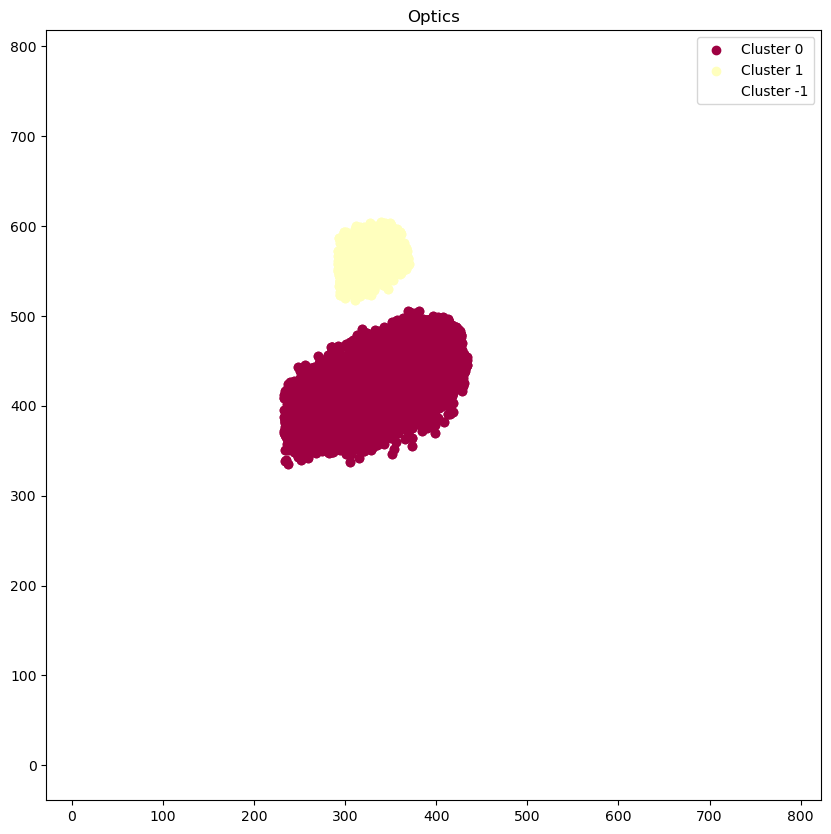

In [28]:
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'none'  #  'k' Czarny kolor dla punktów odstających
        
    class_member_mask = (labels == label)
    xy = data_1[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[color], label='Cluster %d' % label)

plt.title('Optics')
plt.legend(loc='upper right')
plt.show()

In [25]:
start_time = time.time()
optics = OPTICS(max_eps=25, 
                min_samples=500, 
                metric='minkowski',
                n_jobs=4,
               ).fit(data_2)

end_time = time.time()
execution_time = end_time - start_time

labels = optics.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Czas wykonania algorytmu: {execution_time} sekund")

Estimated number of clusters: 5
Estimated number of noise points: 9788
Czas wykonania algorytmu: 127.1895272731781 sekund


In [1]:
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'none'  #  'k' Czarny kolor dla punktów odstających
        
    class_member_mask = (labels == label)
    xy = data_2[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[color], label='Cluster %d' % label)

plt.title('Optics')
plt.legend(loc='upper right')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Definicja modelu DBSCAN
dbscan = OPTICS()

def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.calinski_harabasz_score(X, clusters)
    return score

# Przestrzeń hiperparametrów do przeszukania
param_grid = {
    'max_eps': list(range(1, 40, 5)),
    'min_samples': list(range(200, 701, 5)),
    'metric': ['l1', 'hamming', 'dice', 'jaccard', 'canberra', 'l2', 'cosine', 
               'cityblock', 'euclidean', 'manhattan', 'nan_euclidean', 'braycurtis', 
               'minkowski', 'sokalsneath', 'russellrao', 'seuclidean', 'rogerstanimoto',
               'precomputed', 'yule', 'sokalmichener', 'haversine', 'chebyshev', 
               'correlation', 'sqeuclidean', 'mahalanobis', 'wminkowski', 'matching'],
    'leaf_size': list(range(10, 40, 5)),
}

# Inicjalizacja obiektu HalvingGridSearchCV
grid_search = HalvingGridSearchCV(dbscan, 
                                  param_grid,
                                  scoring=silhouette_score,  
                                  n_jobs=-1)

# Dopasowanie modelu do danych
grid_search.fit(data_1)

# Wydrukowanie najlepszych parametrów
print("Najlepsze parametry:", grid_search.best_params_)

# Wydrukowanie najlepszego wyniku
print("Najlepszy wynik:", grid_search.best_score_)

In [ ]:
# Definicja modelu DBSCAN
dbscan = OPTICS()

def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.calinski_harabasz_score(X, clusters)
    return score

# Przestrzeń hiperparametrów do przeszukania
param_grid = {
    'max_eps': list(range(10, 25, 1)),
    'min_samples': list(range(100, 701, 50)),
}

# Inicjalizacja obiektu HalvingGridSearchCV
grid_search = HalvingGridSearchCV(dbscan, 
                                  param_grid,
                                  scoring=silhouette_score,  
                                  n_jobs=-1)

# Dopasowanie modelu do danych
grid_search.fit(data_2)

# Wydrukowanie najlepszych parametrów
print("Najlepsze parametry:", grid_search.best_params_)

# Wydrukowanie najlepszego wyniku
print("Najlepszy wynik:", grid_search.best_score_)

In [27]:
# Definicja modelu DBSCAN
dbscan = OPTICS()

def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.calinski_harabasz_score(X, clusters)
    return score

# Przestrzeń hiperparametrów do przeszukania
param_grid = {
    'max_eps': list(range(1, 10, 1)),
    'min_samples': list(range(50, 500, 25)),
}

# Inicjalizacja obiektu HalvingGridSearchCV
grid_search = HalvingGridSearchCV(dbscan, 
                                  param_grid,
                                  scoring=silhouette_score,  
                                  n_jobs=-1)

# Dopasowanie modelu do danych
grid_search.fit(data_3)

# Wydrukowanie najlepszych parametrów
print("Najlepsze parametry:", grid_search.best_params_)

# Wydrukowanie najlepszego wyniku
print("Najlepszy wynik:", grid_search.best_score_)

C:\Users\kamil\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\kamil\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [         nan          nan          na

OSError: [Errno 22] Invalid argument